# Road detection in satellite imagery from rural areas - intro and questions

Our task is to detect roads in satellite images from rural areas, exemplified by Borneo and Harz (a rural area not too far from Berlin). So, this is a pixel-level classification task; the simple version is binary (road vs. no road), the more advanced taks is ternary (paved road, unpaved road, no road). We use a convolutional network (U-net) which works reasonably well, see analysis_network_results notebook. However, it's hard for us to compare our results to a baseline because to our knowledge there have been no attempts at detecting roads in rural areas so far (on urban areas there are many). So, the rationale is to establish some sort of baseline (or call it comparison to the Deep Learning approach) by employing more 'classical' ML approaches.

The present notebook is a first and very preliminary stab at this, using Scikit-learn. Time permitting, I would like to 
* run this in a model pipeline
* try out additional models (SVM, etc)
* run a grid search to find the best parameters
* engineer additional features (it's obvious that in this task context matters - if a given pixel is on a road, chances are high that its neighbors are, too)

Concrete questions:
* in image segmentation tasks it's by definition all about context (pixel neighborhood; see exemplary scatter plot below to see that pure pixel values are of limited predictive value, at least for that (admittedly extreme) data subset). I understand that there is no fixed concept of a baseline, but - is a context-free or context-poor approach outlined here 'fair' at all for a baseline? 
* our data set is far too large to fit into memory at once, so we need to run it in batches. I haven't found a dedicated method in Scikit-learn to do that - is there one I overlooked? It's no problem to implement this manually, iterating over groups of satellite image tiles and setting warm_start to True, or can you think of a better way?
* what other models do you think would be a good fit for the task? 
* our classes are very very imbalanced, no road >> unpaved road > paved road. My approach would be to downsample the no road class. I presume adjusting class_weight also makes sense?
* for model evaluation, we use precision-recall curves because of said imbalance. Any other metric that comes to your mind that would be indispensable?


In [1]:
%load_ext autoreload
%autoreload 2

#from keras.layers import merge
from src.data import utils
from src.models.data import *
from src.models.model import *
from src.models.predict_model import *
from src.data.utils import get_tile_prefix

from sklearn.externals import joblib
from sklearn.ensemble import RandomForestClassifier

from pathlib import Path
import os, shutil
import sys
import time
%matplotlib inline

Using TensorFlow backend.


## User settings

In [2]:
# paths to append
sys.path.append("/home/ubuntu/roaddetection/")
sys.path.append("/media/hh/hd_internal/hh/DSR_Berlin_2018/roaddetection/")

# base directories with data (image tiles) to be analyzed
base_dir = "../../data"
dirs = []
train_dir = os.path.join(base_dir, "train")
dirs.append(train_dir)
validation_dir = os.path.join(base_dir, "validate")
dirs.append(validation_dir)
# subdirs
dir_x = 'sat'
dir_y = 'map'

# max. number of samples (files) to analyze
max_num_x = 20

# ------------- image characteristics -----------------------------
# size of tiles
target_size = (512,512)


#--------------- model ----------------------------------------------------
# set to True if a binary model shall be run
model_is_binary = True
# path to & filename of model to save
trained_model_fn = '../../models/RandomForest_binary.pkl'
if True:
    # set to True if a binary model shall be run
    model_is_binary = True
    # path to & filename of model to save
    trained_model_fn = '../../models/RandomForest_multiclass.pkl'

#--------------- training details / hyperparameters -----------------------------------



In [3]:
# obtain list and number of available samples (files)
file_list_x, num_x = utils.get_list_samplefiles(os.path.join(train_dir, dir_x))

# actual number of samples that will be used for training, given samples available and user's choice
num_x_use = min(num_x, max_num_x)


### Define model

In [4]:

mdl = RandomForestClassifier(
    n_estimators=10,
    criterion='gini',
    max_depth=None,
    min_samples_split=6,
    min_samples_leaf=10,
    min_weight_fraction_leaf=0.0,
    max_features='auto',
    max_leaf_nodes=None,
    min_impurity_decrease=0.0,
    min_impurity_split=None,
    bootstrap=True,
    oob_score=False,
    n_jobs=-1,
    random_state=None,
    verbose=1,
    warm_start=False,
    class_weight=None)



### Load data

In [5]:
CLASS_DICT = get_class_dict()
# 
num_features = 4
# number of pixels per image
img_size = np.prod(target_size)
# preallocate arrays collecting features (x) and labels (y) of all samples
arr_x = np.empty((img_size * num_x_use, num_features), dtype=np.float32)
arr_y = np.empty(img_size * num_x_use, dtype=np.uint8)


for i, fn in enumerate(file_list_x[:num_x_use]):
    # read sat image tile
    x = io.imread(os.path.join(train_dir, dir_x, fn))
    # read corresponding label tile
    y = io.imread(os.path.join(train_dir, dir_y, fn))  
    # refactor labels
    y, mask = refactor_labels(x, y, class_dict=CLASS_DICT, model_is_binary=model_is_binary, meta=None)
    # scale x
    x = x/255.0
    print("{0:s}: ({1:0.0f} % non-image pixels)...".format(fn, 100*np.sum(mask)/img_size))
    # copy flattened features and labels in arrays
    arr_y[i*img_size:(i+1)*img_size] = y.reshape(img_size, order = 'C')
    arr_x[i*img_size:(i+1)*img_size,:] =x.reshape((img_size, num_features), order = 'C')
    
# retain all except no_img values
good_ix = arr_y != CLASS_DICT["no_img"]
arr_x = arr_x[good_ix, :]
arr_y = arr_y[good_ix]
print("{} classes present in data".format(len(np.unique(arr_y))))


20180419_074323_0c43_3B_0014.tif: (0 % non-image pixels)...
20180419_074323_0c43_3B_0015.tif: (0 % non-image pixels)...
20180419_074323_0c43_3B_0016.tif: (0 % non-image pixels)...
20180419_074323_0c43_3B_0017.tif: (0 % non-image pixels)...
20180419_074323_0c43_3B_0018.tif: (0 % non-image pixels)...
20180419_074323_0c43_3B_0019.tif: (0 % non-image pixels)...
20180419_074323_0c43_3B_0020.tif: (0 % non-image pixels)...
20180419_074323_0c43_3B_0021.tif: (1 % non-image pixels)...
20180419_074323_0c43_3B_0022.tif: (6 % non-image pixels)...
20180419_074323_0c43_3B_0023.tif: (14 % non-image pixels)...
20180419_074323_0c43_3B_0024.tif: (21 % non-image pixels)...
20180419_074323_0c43_3B_0025.tif: (28 % non-image pixels)...
20180419_074323_0c43_3B_0026.tif: (31 % non-image pixels)...
20180419_074323_0c43_3B_0000.tif: (31 % non-image pixels)...
20180419_074323_0c43_3B_0001.tif: (9 % non-image pixels)...
20180419_074323_0c43_3B_0002.tif: (16 % non-image pixels)...
20180419_074323_0c43_3B_0003.tif: 

## Quick look at exemplary data
Plot of pixel values in blue-green-infrared space; road pixels are red, no road pixels gray

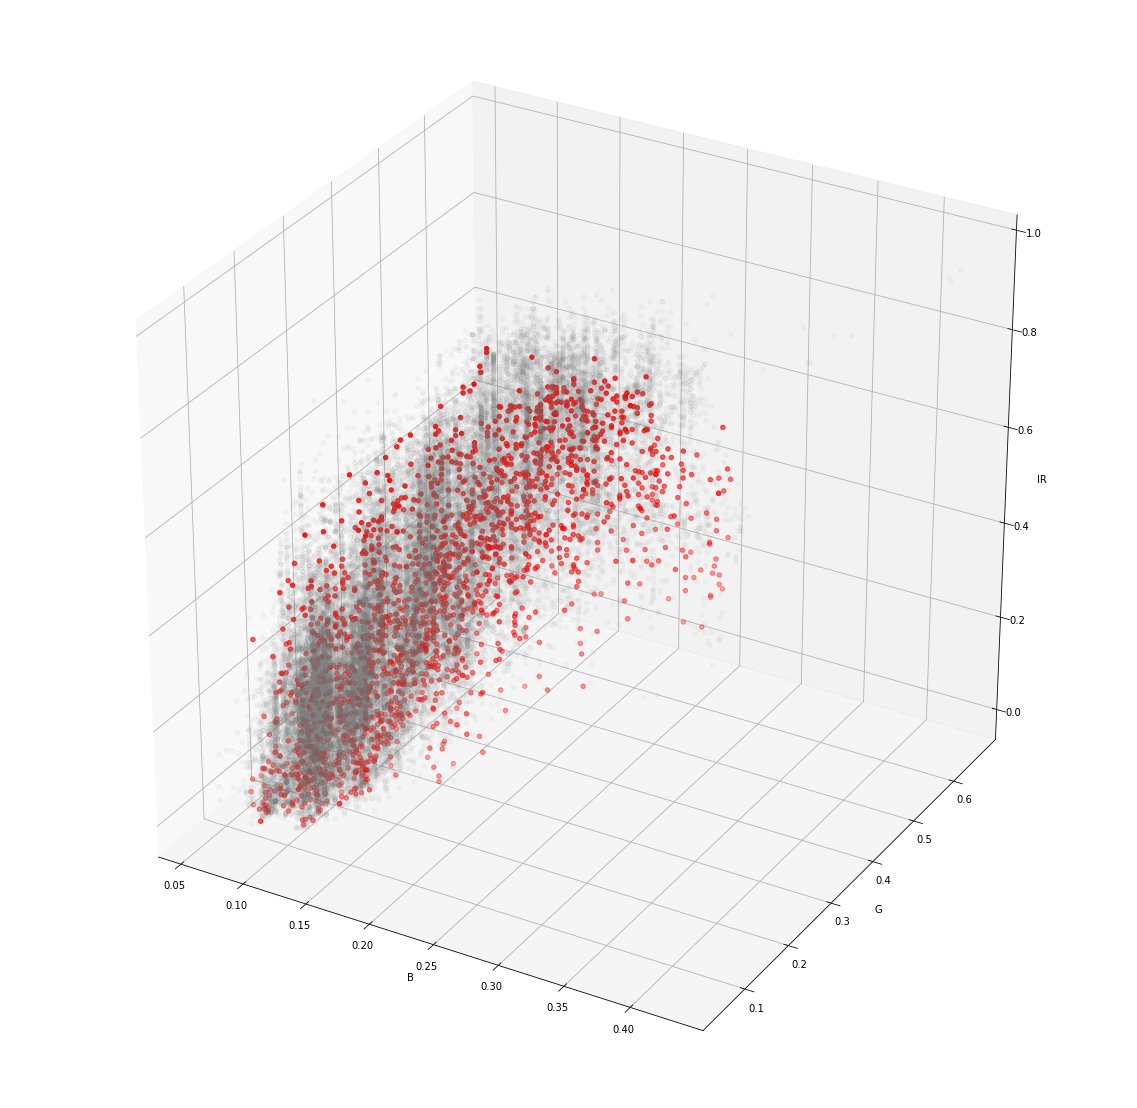

In [6]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np

# downsample for plot
arr_x_plot = arr_x[::100,:]
arr_y_plot = arr_y[::100]


fig = plt.figure(figsize=(20,20))
ax = fig.add_subplot(111, projection='3d')
ix = arr_y_plot == 40
ax.scatter(arr_x_plot[ix,0], arr_x_plot[ix,1], arr_x_plot[ix,3], c="gray", alpha=0.05)  # , c=c, marker=m
ix = arr_y_plot == 200
ax.scatter(arr_x_plot[ix,0], arr_x_plot[ix,1], arr_x_plot[ix,3], c="red")  # , c=c, marker=m


ax.set_xlabel('B')
ax.set_ylabel('G')
ax.set_zlabel('IR')

plt.show()

### Run training

In [7]:
t1 = time.time()
mdl.fit(arr_x, arr_y)
t2 = time.time()
print("Model fitting finished after {0:0.0f} s wall clock time".format(t2-t1))

Model fitting finished after 16 s wall clock time


[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:   16.1s finished


In [8]:
mdl.feature_importances_

array([0.17399424, 0.20187715, 0.20386355, 0.42026505])